In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import svm
import statsmodels.api as sm
import pywt
import copy
import warnings
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller
from sklearn.ensemble import GradientBoostingRegressor as GBR
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, r2_score
from model import WT, AR_MA, NonlinReg, ModelEvaluation
import datetime

In [2]:
hdfc_data = pd.read_csv('HDFC.daily.csv')
hdfc_data.head()

,symbol,t,o,h,l,c,v
0,HDFC,983232000,57.40,59.7,57.40,59.13,1927790
1,HDFC,983318400,59.70,62.1,58.68,59.35,7308190
2,HDFC,983404800,60.48,60.9,58.61,59.85,3468220
3,HDFC,983491200,60.50,60.8,55.30,55.61,2408840
4,HDFC,983750400,55.51,57.4,51.64,52.62,2452810


In [3]:
hdfc_data['datetime'] = hdfc_data['t'].apply(lambda x: datetime.datetime.fromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S'))

In [4]:
hdfc_data = hdfc_data.loc[:,['symbol','o','h','l','c','datetime']].rename(columns = {'o':'open','h':'high','l':'low','c':'close'})
hdfc_data.head()

,symbol,open,high,low,close,datetime
0,HDFC,57.40,59.7,57.40,59.13,2001-02-27 05:30:00
1,HDFC,59.70,62.1,58.68,59.35,2001-02-28 05:30:00
2,HDFC,60.48,60.9,58.61,59.85,2001-03-01 05:30:00
3,HDFC,60.50,60.8,55.30,55.61,2001-03-02 05:30:00
4,HDFC,55.51,57.4,51.64,52.62,2001-03-05 05:30:00


In [5]:
hdfc_data['datetime'] = pd.to_datetime(hdfc_data['datetime'])
hdfc_data['time'] = hdfc_data['datetime'].dt.strftime('%H:%M:%S')
hdfc_data['date'] = pd.to_datetime(hdfc_data['datetime'].dt.date) 

In [6]:
hdfc_data.head()

,symbol,open,high,low,close,datetime,time,date
0,HDFC,57.40,59.7,57.40,59.13,2001-02-27 05:30:00,05:30:00,2001-02-27
1,HDFC,59.70,62.1,58.68,59.35,2001-02-28 05:30:00,05:30:00,2001-02-28
2,HDFC,60.48,60.9,58.61,59.85,2001-03-01 05:30:00,05:30:00,2001-03-01
3,HDFC,60.50,60.8,55.30,55.61,2001-03-02 05:30:00,05:30:00,2001-03-02
4,HDFC,55.51,57.4,51.64,52.62,2001-03-05 05:30:00,05:30:00,2001-03-05


In [7]:
hdfc_data.date.max()

Timestamp('2021-02-24 00:00:00')

In [8]:
hdfc_data.date.min()

Timestamp('2001-02-27 00:00:00')

In [9]:
# start_day = '2010-01-04'
# end_day = '2012-12-27'
test = hdfc_data.loc[:,['date','close']].set_index('date')
# test = test.loc[start_day:end_day,:]

test_C = test['close']


In [10]:
test_C

date
2001-02-27      59.13
2001-02-28      59.35
2001-03-01      59.85
2001-03-02      55.61
2001-03-05      52.62
               ...   
2021-02-18    2745.15
2021-02-19    2741.30
2021-02-22    2651.95
2021-02-23    2628.60
2021-02-24    2638.55
Name: close, Length: 4973, dtype: float64

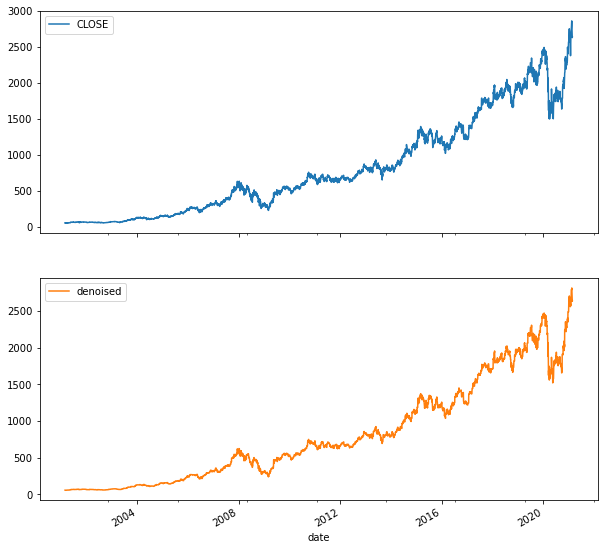

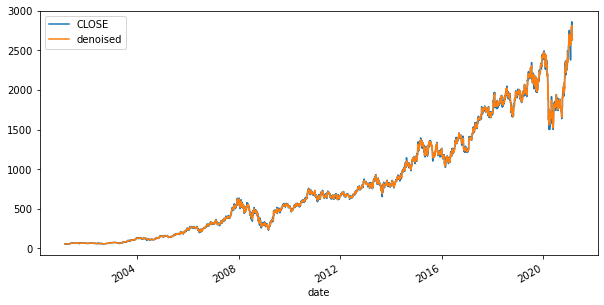

In [11]:

coeff = WT(test_C, plot=True)

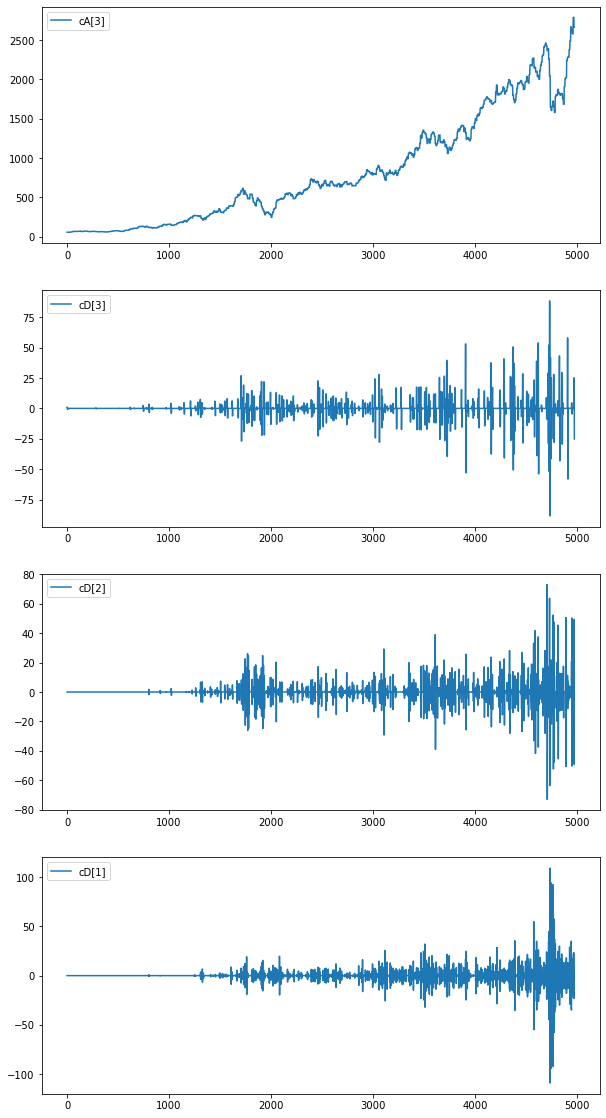

In [12]:
fig, ax =  plt.subplots(len(coeff), 1, figsize=(10, 20))
for i in range(len(coeff)):
    if i == 0:
        ax[i].plot(coeff[i], label = 'cA[%.0f]'%(len(coeff)-i-1))
        ax[i].legend(loc = 'best')
    else:
        ax[i].plot(coeff[i], label = 'cD[%.0f]'%(len(coeff)-i))
        ax[i].legend(loc = 'best')

# ARMA Model

In [13]:
for i in range(1, len(coeff)):
    dftest = adfuller(coeff[i], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical value(%s)' % key] = value
    print((pd.DataFrame(dfoutput, columns=['cD[%.0f]'%(len(coeff)-i)])))
    print('\n')

                                    cD[3]
Test Statistic              -1.731997e+01
p-value                      5.489026e-30
#Lags Used                   3.200000e+01
Number of observations Used  4.940000e+03
Critical value(1%)          -3.431674e+00
Critical value(5%)          -2.862125e+00
Critical value(10%)         -2.567082e+00


                                   cD[2]
Test Statistic                -19.848693
p-value                         0.000000
#Lags Used                     32.000000
Number of observations Used  4940.000000
Critical value(1%)             -3.431674
Critical value(5%)             -2.862125
Critical value(10%)            -2.567082


                                   cD[1]
Test Statistic                -20.815694
p-value                         0.000000
#Lags Used                     32.000000
Number of observations Used  4940.000000
Critical value(1%)             -3.431674
Critical value(5%)             -2.862125
Critical value(10%)            -2.567082




Use ADF test to test the stationarity of reconstructed detail component. We can find all detail components pass the test, since the p-value is extremely small

The premise of ARMA(p, q) is that the time series must be stationary. And it can be proved that all the reconstructed detail component of wavelet tranformed sequence is stationary sequence

In [14]:
results = AR_MA(coeff)

1
2
3


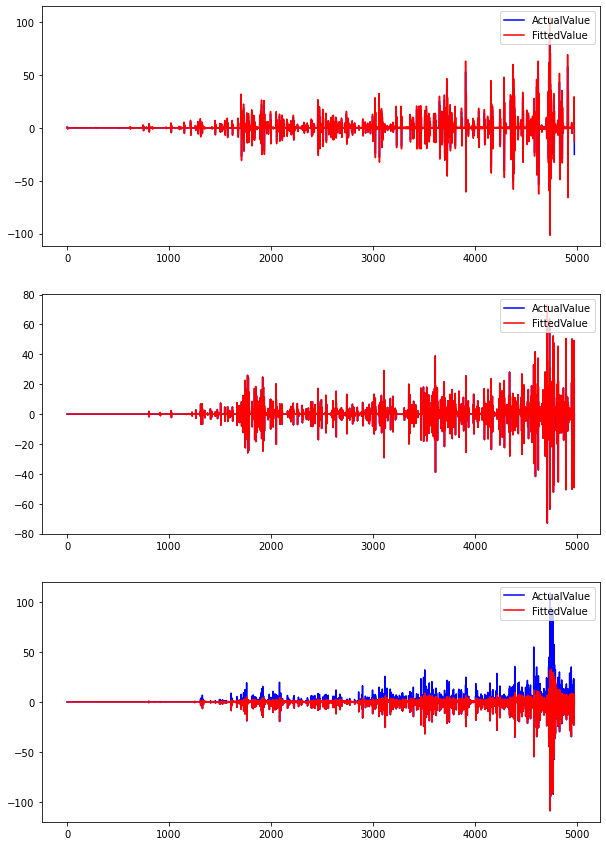

In [15]:
plt.figure(figsize=(10,15))
for i in range(len(results)):
    plt.subplot(len(results), 1, i+1)
    plt.plot(coeff[i+1], 'blue', label='ActualValue')
    plt.legend(loc='upper right')
    plt.plot(results[i].fittedvalues, 'red', label='FittedValue')
    plt.legend(loc='upper right')

In [16]:
for i in range(len(results)):
    print(results[i].fittedvalues)
    print(len(results[i].fittedvalues))

[ 5.85052262e-03  4.80369458e-01  3.86901595e-01 ...  2.94306576e+01
  1.97651118e+01 -1.29356617e+01]
4973
[ 2.56846114e-03  2.04795794e-03  3.40574220e-03 ... -3.69071526e+01
 -4.92127083e+01  2.40510470e+01]
4973
[ 5.55775459e-04  9.32032279e-04  1.10896079e-03 ...  4.66742406e+00
 -7.96705536e+00  5.87515298e+00]
4973


In [17]:
len(results)

3

In [20]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

def __svm_forecast(data, sample_size=150):
    '''
    Paritions "data" and fits an SVM model to this data, then forecasts the
    value one time-step into the future
    '''
    X, y = __partition_array(data, size=sample_size)

    param_grid = {'C': [.05, .1, .5, 1, 5, 10], 'epsilon': [0.001, 0.005, 0.01, 0.05, 0.1]}
    gsc = GridSearchCV(SVR(), param_grid, scoring='neg_mean_squared_error')
    
    model = gsc.fit(X, y).best_estimator_

#     return model.predict(data[np.newaxis, -sample_size:])[0]
    return model.predict(data[np.newaxis, -sample_size:])

def __partition_array(arr, size=None, splits=None):
    '''
    partitions 1-D array "arr" in a Rolling fashion if "size" is specified, 
    else, divides the into "splits" pieces

    returns: list of paritioned arrays, list of the values 1 step ahead of each partitioned array
    '''

    arrs = []
    values = []

    if not (bool(size is None) ^ bool(splits is None)):
        raise ValueError('Size XOR Splits should not be None')

    if size:
        arrs = [arr[i:i + size] for i in range(len(arr) - size)]
        values = [arr[i] for i in range(size, len(arr))]

    elif splits:
        size = len(arr) // splits
        if len(arr) % size == 0:
            arrs = [arr[i:i + size] for i in range(size - 1, len(arr) - 1, size)]
            values = [arr[i] for i in range(2 * size - 1, len(arr), size)]
        else:
            arrs = [arr[i:i + size] for i in range(len(arr) % size - 1, len(arr) - 1, size)]
            values = [arr[value].iloc[i] for i in range(len(arr) % size + size - 1, len(arr), size)]

    return np.array(arrs), np.array(values)

In [21]:
threshold = 0.5
for i in range(len(coeff)):
    if i > 0:
        # we don't want to threshold the approximation coefficients
        coeff[i] = pywt.threshold(coeff[i], threshold*max(coeff[i]))
    forecasted = __svm_forecast(coeff[i])
    print(forecasted)
    coeff[i] = np.roll(coeff[i], -1)
    coeff[i][-1] = forecasted

[2073.44613935]
[0.001]
[0.00085748]
[0.00100906]


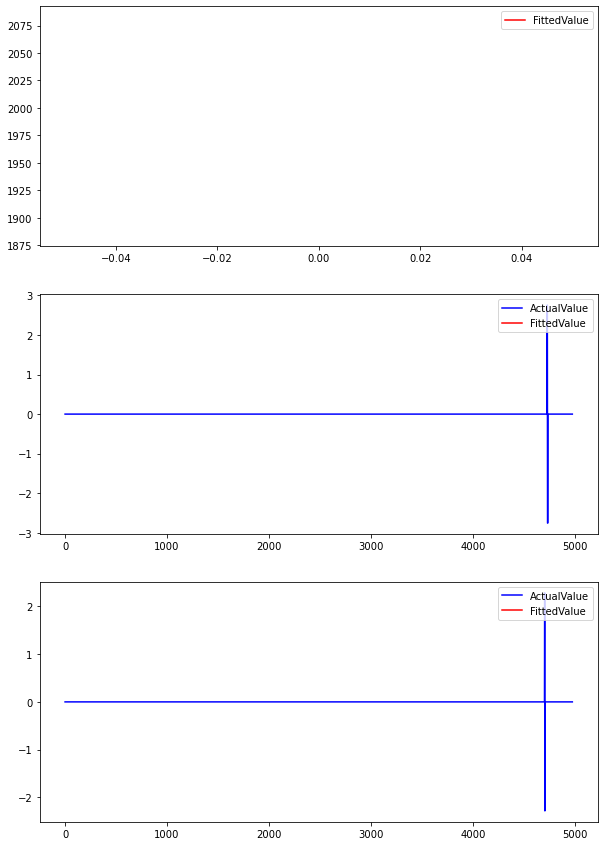

In [34]:
plt.figure(figsize=(10,15))
for i in range(len(results)):
    plt.subplot(len(results), 1, i+1)
    if i > 0:
        # we don't want to threshold the approximation coefficients
        coeff[i] = pywt.threshold(coeff[i], threshold*max(coeff[i]))
        plt.plot(coeff[i], 'blue', label='ActualValue')
        plt.legend(loc='upper right')
    forecasted = __svm_forecast(coeff[i],sample_size=10)
    plt.plot(forecasted, 'red', label='FittedValue')
    plt.legend(loc='upper right')
    coeff[i] = np.roll(coeff[i], -1)
    coeff[i][-1] = forecasted
#     plt.subplot(len(results), 1, i+1)
#     plt.plot(coeff[i+1], 'blue', label='ActualValue')
#     plt.legend(loc='upper right')
#     plt.plot(forecasted, 'red', label='FittedValue')
#     plt.legend(loc='upper right')

In [32]:
len(coeff)

4

In [18]:
# features = 4
# forward =30
# window = 150
# length = 1
# index_predict1, index_real1 = [], []
# for i in range(forward):
#     test_window = test_C[i:i+window]
#     coeff = WT(test_window)
#     coeff[3]
#     results = AR_MA(coeff)
#     Y_ = NonlinReg(coeff, regressor='SVR', length=length, features = features)[-1:]
#     D_series = []
#     for j in range(len(results)):
#         D_series.append(results[j].predict(window, window+length-1, dynamic=True))
#     index_predict1.append(Y_)
#     index_real1.append(test_C[i+window:i+window+length].values)

In [19]:
# features = 4 # this number is derived from the paper "The stock price based on the ARIMA_SVM combination model _ cheng changpin.(Chinese)". Since the prediction is the best when using 4 days close price to predict
# forward =30
# window = 150 # the rolling window should be as large as possible. Better larger than 100, since the time series ARMA model can't get inverted matrics if the time series is too short 
# length = 1
# index_predict, index_real = [], []
# for i in range(forward):
#     test_window = test_C[i:i+window]
#     coeff = WT(test_window)
#     print(len(coeff))
#     results = AR_MA(coeff)
#     print(len(results))
# #     Y_ = NonlinReg(coeff, regressor='GBR', length=length, features = features)[-1:]
# #     D_series = []
# #     for j in range(len(results)):
# #         D_series.append(results[j].predict(window, window+length-1, dynamic=True))
# #     index_predict.append(Y_)
# #     index_real.append(test_C[i+window:i+window+length].values)